# YOLO Velo Baseline + Debugging (AI Projektarbeit)

**Autor:** Dominic Wagenhofer  
**Modul:** EDS – Artificial Intelligence (HSLU)  
**Abgabe:** Video (≤10 min) + *ein* dokumentiertes Python Notebook auf GitHub  

Dieses Notebook ist so aufgebaut, dass im Video der typische rote Faden **Fragestellung → Inputdaten → Methodik → Resultate → Interpretation** einfach erklärt werden kann. Ausserdem enthält es einen klaren Abschnitt **Debugging & Failure-Mode-Analyse**, um zu zeigen, dass das Modell verstanden wurde. fileciteturn1file0

## 1. Problemstellung, Zielsetzung, Metrik

**Kontext (Warum relevant?)**  
Veloparkierungsanlagen (z.B. am Bahnhof) sind oft zu Spitzenzeiten überlastet. Eine automatische Schätzung der Belegung aus Videoaufnahmen kann Planung, Betrieb und Monitoring unterstützen.

**Ziel (Was soll das Modell tun?)**  
Ein vortrainiertes YOLO-Modell soll **Fahrräder in Video-Frames erkennen** (Bounding Boxes) und daraus **eine Belegungs-Zeitreihe** erzeugen (Anzahl erkannter Velos pro Frame / Zeit).

**Metrik (Wie wird Erfolg gemessen?)**  
Da es sich um ein Baseline-Projekt ohne Finetuning handelt, wird der Erfolg über zwei Ebenen beurteilt:
- **Qualitativ:** Visuelle Plausibilität der Bounding Boxes (stimmen Boxen und Klassen?).
- **Quantitativ (lightweight):** Manuelle Zählung in einer kleinen Stichprobe von Frames (z.B. 20) und Vergleich mit YOLO: **MAE** und **MAPE**.

## 2. Setup & Ordnerstruktur

Erwartete Struktur im Repository (ohne grosse Dateien auf GitHub):
```
eds-ai-git/
  notebooks/
    01_yolo_velo_baseline_debug.ipynb   # dieses Notebook
  data/
    README.md                           # beschreibt lokale Dateien
    (lokal) velo_park.mp4               # **nicht** ins Git pushen
```

**Wichtig (GitHub Limit):** Videos (\*.mp4) gehören nicht ins Repo (GitHub blockiert >100MB). Sie bleiben lokal und werden via `.gitignore` ausgeschlossen.

Dieses Notebook ist so geschrieben, dass es **auch ohne Video im Repo** sauber startet und hilfreiche Fehlermeldungen ausgibt.

In [8]:
# ============================================================
# 3. Imports & Konfiguration
# ============================================================
# Jede Zeile ist kommentiert, damit klar ist, was passiert.

from pathlib import Path                    # Für robuste Pfad-Operationen (plattformunabhängig)
import os                                   # Für Umgebungsvariablen / Systeminfos
import random                               # Für reproduzierbare Stichproben
import math                                 # Für einfache mathematische Funktionen
import numpy as np                          # Numerik (Arrays, Statistik)
import pandas as pd                         # Tabellen / Auswertung der Detections
import cv2                                  # OpenCV: Video-Read, Frames
import matplotlib.pyplot as plt             # Plots (Zeitreihe, Histogramme)

from ultralytics import YOLO                # Ultralytics YOLOv8 API (vortrainiertes Modell)

# ----------------------------
# Reproduzierbarkeit
# ----------------------------
RANDOM_SEED = 42                            # Fixer Seed für reproduzierbare Stichproben
random.seed(RANDOM_SEED)                    # Python-Random deterministisch machen
np.random.seed(RANDOM_SEED)                 # NumPy-Random deterministisch machen

# ----------------------------
# Pfade (Repo-Root annehmen)
# ----------------------------
REPO_ROOT = Path.cwd()                      # Aktuelles Arbeitsverzeichnis (dort, wo Jupyter gestartet wurde)
DATA_DIR = REPO_ROOT / "data"               # Lokaler Datenordner (Video liegt hier lokal)
OUTPUT_DIR = REPO_ROOT / "notebooks" / "outputs"  # Ausgabeordner innerhalb des Repo
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)     # Ordner anlegen, falls nicht vorhanden

# ----------------------------
# Video-File (anpassen!)
# ----------------------------
VIDEO_PATH = Path("data/velopark.mp4")      #Standard-Name: data/velo_park.mp4 (lokal)

# ----------------------------
# YOLO Modell wählen
# ----------------------------
# yolov8n = "nano" (schnell, weniger präzise), gut als Baseline.
MODEL_NAME = "yolov8n.pt"                   # Vortrainiertes COCO-Modell (downloaded automatisch bei erstem Run)

# ----------------------------
# Inferenz-Parameter
# ----------------------------
CONF_THRES = 0.25                           # Confidence-Schwelle (zu niedrig -> viele False Positives; zu hoch -> Unterzählung)
IOU_THRES  = 0.45                           # IoU-Schwelle (NMS), beeinflusst, ob nahe Boxen zusammengefasst werden
FRAME_STRIDE = 5                            # Nur jeden 5. Frame auswerten (Performance). Für sehr kurze Videos ggf. 1 setzen.

# ----------------------------
# COCO Klassen-IDs (YOLOv8 COCO)
# ----------------------------
# In COCO ist "bicycle" typischerweise class_id=1.
# Wir halten das trotzdem flexibel und prüfen später die Klassennamen im Modell.
BICYCLE_CLASS_ID = 1

print("Repo-Root:", REPO_ROOT)
print("Erwarte Video unter:", VIDEO_PATH)


Repo-Root: /Users/dominicwagenhofer/Desktop/Studium/7. Semester/Artificial Intelligence/Einzelarbeit/Git Repo/eds-ai-git/notebooks
Erwarte Video unter: data/velopark.mp4


In [9]:
# ============================================================
# 4. Modell laden + Klassen prüfen
# ============================================================

# YOLO Modell laden (wird bei erstem Mal ggf. automatisch heruntergeladen)
model = YOLO(MODEL_NAME)

# Klassennamen anzeigen, um sicherzugehen, dass bicycle vorhanden ist
# model.names ist ein dict: {class_id: "class_name"}
names = model.names
print("Anzahl Klassen:", len(names))
print("Beispiel Klassen:", list(names.items())[:10])
print("Bicycle class name:", names.get(BICYCLE_CLASS_ID, "UNKNOWN"))


Anzahl Klassen: 80
Beispiel Klassen: [(0, 'person'), (1, 'bicycle'), (2, 'car'), (3, 'motorcycle'), (4, 'airplane'), (5, 'bus'), (6, 'train'), (7, 'truck'), (8, 'boat'), (9, 'traffic light')]
Bicycle class name: bicycle


In [10]:
# ============================================================
# 5. Video-Check & Metadaten
# ============================================================

def open_video_or_raise(video_path: Path) -> cv2.VideoCapture:
    """Öffnet ein Video mit OpenCV oder wirft eine verständliche Fehlermeldung."""
    if not video_path.exists():  # Prüfen, ob Datei existiert
        raise FileNotFoundError(
            f"Video nicht gefunden: {video_path}\n"
            f"Lege dein Video lokal unter 'data/velo_park.mp4' ab (nicht ins Git pushen)."
        )
    cap = cv2.VideoCapture(str(video_path))   # VideoCapture öffnen
    if not cap.isOpened():                   # Prüfen, ob OpenCV das Video öffnen konnte
        raise RuntimeError(
            "OpenCV konnte das Video nicht öffnen. Mögliche Gründe:\n"
            "- Codec/Format wird nicht unterstützt\n"
            "- Datei ist beschädigt\n"
            "- Pfad stimmt nicht"
        )
    return cap

def get_video_meta(cap: cv2.VideoCapture) -> dict:
    """Liest grundlegende Video-Metadaten aus."""
    fps = cap.get(cv2.CAP_PROP_FPS)                          # Frames pro Sekunde
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))     # Anzahl Frames
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))           # Frame-Breite
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))         # Frame-Höhe
    duration_s = frame_count / fps if fps else None          # Dauer in Sekunden (falls fps verfügbar)
    return {
        "fps": fps,
        "frame_count": frame_count,
        "width": width,
        "height": height,
        "duration_s": duration_s
    }

# Video öffnen (wenn nicht vorhanden, kommt eine klare Fehlermeldung)
cap = open_video_or_raise(VIDEO_PATH)
meta = get_video_meta(cap)

print("Video-Metadaten:")
for k, v in meta.items():
    print(f"  - {k}: {v}")

cap.release()  # Wichtig: wieder schließen, damit wir später sauber neu öffnen können


Video-Metadaten:
  - fps: 29.988933972703798
  - frame_count: 271
  - width: 1080
  - height: 1920
  - duration_s: 9.036666666666667


In [11]:
# ============================================================
# 6. Kern-Algorithmus: Detection pro Frame
# ============================================================
# Idee:
# - Wir lesen das Video Frame für Frame
# - Wir lassen YOLO auf ausgewählten Frames laufen (FRAME_STRIDE)
# - Wir speichern alle Detections in einem DataFrame, damit wir:
#     (a) die Belegung (bike_count) pro Frame berechnen können
#     (b) später Debugging/Fault Analysis machen können

def run_yolo_on_video(
    video_path: Path,
    frame_stride: int = 1,
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
    max_frames: int | None = None
) -> pd.DataFrame:
    """Führt YOLO auf einem Video aus und gibt alle Detections als DataFrame zurück."""
    cap = open_video_or_raise(video_path)                 # Video öffnen
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0               # FPS lesen (Fallback 30)

    rows = []                                             # Hier sammeln wir Detections als dicts
    frame_idx = 0                                         # Aktueller Frame-Index
    processed = 0                                         # Anzahl tatsächlich verarbeiteter Frames

    while True:
        ret, frame_bgr = cap.read()                       # Nächsten Frame lesen (BGR)
        if not ret:                                       # Ende des Videos
            break

        # Frame-Striding: Nur jeden n-ten Frame auswerten
        if frame_idx % frame_stride != 0:
            frame_idx += 1
            continue

        # Optional: Stop nach max_frames (Debug/Speed)
        if max_frames is not None and processed >= max_frames:
            break

        # YOLO Inferenz:
        # - Wir geben das Frame (np.array) direkt rein
        # - conf/iou steuern NMS & Filterung
        results = model.predict(
            source=frame_bgr,                             # Eingabe-Frame
            conf=conf_thres,                              # Confidence threshold
            iou=iou_thres,                                # IoU threshold for NMS
            verbose=False                                 # Keine extra Logs pro Frame
        )

        # results[0].boxes enthält die Boxen für diesen Frame
        r0 = results[0]
        boxes = r0.boxes

        # Falls keine Boxen, speichern wir trotzdem "0" über einen speziellen Eintrag nicht.
        # Für die Zeitreihe genügt es, später per groupby fehlende Frames als 0 zu behandeln.
        if boxes is not None and len(boxes) > 0:
            # Box-Koordinaten (xyxy) und Scores/Klassen holen
            xyxy = boxes.xyxy.cpu().numpy()               # [x1,y1,x2,y2]
            conf = boxes.conf.cpu().numpy()               # Confidence je Box
            cls  = boxes.cls.cpu().numpy().astype(int)    # Klasse je Box

            for (x1, y1, x2, y2), c, cl in zip(xyxy, conf, cls):
                # Alles in eine Zeile packen (für Auswertung/Debug)
                rows.append({
                    "frame_idx": frame_idx,
                    "time_s": frame_idx / fps,            # Zeitstempel in Sekunden
                    "class_id": int(cl),
                    "class_name": names.get(int(cl), str(cl)),
                    "conf": float(c),
                    "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
                    "w": float(x2 - x1),
                    "h": float(y2 - y1),
                    "area": float((x2 - x1) * (y2 - y1)),
                    "aspect": float((x2 - x1) / (y2 - y1 + 1e-9)),  # w/h (stabilisiert)
                })

        processed += 1
        frame_idx += 1

    cap.release()                                         # Video schließen

    df = pd.DataFrame(rows)                               # DataFrame bauen
    return df

# Beispiel-Run (kann je nach Video dauern):
# Tipp: zuerst max_frames klein halten (z.B. 200) und FRAME_STRIDE z.B. 5.
df_det = run_yolo_on_video(
    VIDEO_PATH,
    frame_stride=FRAME_STRIDE,
    conf_thres=CONF_THRES,
    iou_thres=IOU_THRES,
    max_frames=None  # setze z.B. 300 für einen schnellen Testlauf
)

print("Detections-DataFrame erstellt.")
print("Zeilen (Detections):", len(df_det))
display(df_det.head(10))


Detections-DataFrame erstellt.
Zeilen (Detections): 332


,frame_idx,time_s,class_id,class_name,conf,x1,y1,x2,y2,w,h,area,aspect
0,0,0.000000,2,car,0.866551,792.832947,428.827179,1076.424805,602.614380,283.591858,173.787201,49284.636719,1.631834
1,0,0.000000,2,car,0.865766,586.752930,412.206848,935.059448,620.261902,348.306519,208.055054,72466.929688,1.674107
2,0,0.000000,1,bicycle,0.689972,465.792755,579.458923,898.607483,877.147705,432.814728,297.688782,128844.085938,1.453917
3,0,0.000000,0,person,0.644020,82.186226,339.516968,124.087852,460.426849,41.901627,120.909882,5066.320801,0.346553
4,0,0.000000,1,bicycle,0.414424,383.016357,486.851257,635.312317,809.753540,252.295959,322.902283,81466.937500,0.781338
5,0,0.000000,0,person,0.350086,99.822556,354.711395,131.671509,461.001099,31.848953,106.289703,3385.215820,0.299643
6,0,0.000000,0,person,0.284229,57.809235,354.562225,79.312431,454.559143,21.503197,99.996918,2150.253418,0.215039
7,5,0.166728,2,car,0.741601,798.147949,456.852448,1075.198364,632.487732,277.050415,175.635284,48659.828125,1.577419
8,5,0.166728,2,car,0.705804,597.266052,440.295593,940.100830,639.762085,342.834778,199.466492,68384.046875,1.718759
9,5,0.166728,1,bicycle,0.681791,463.001221,570.320312,926.142334,941.038757,463.141113,370.718445,171694.953125,1.249307


Zeitreihe berechnet. Frames mit mindestens 1 Bike: 55


,frame_idx,time_s,bike_count
0,0,0.000000,2
1,5,0.166728,2
2,10,0.333456,2
3,15,0.500185,3
4,20,0.666913,1
5,25,0.833641,4
6,30,1.000369,3
7,35,1.167097,4
8,40,1.333825,2
9,45,1.500554,1


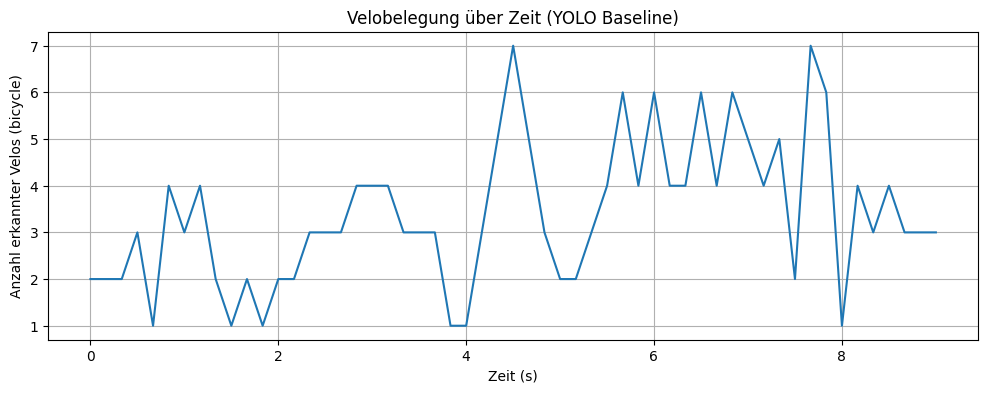

Max erkannte Velos: 7
Ø erkannte Velos: 3.4


In [12]:
# ============================================================
# 7. Resultate: Belegung (bike_count) über die Zeit
# ============================================================

def compute_bike_count_timeseries(df_det: pd.DataFrame) -> pd.DataFrame:
    """Berechnet bike_count pro Frame (nach COCO-Klasse bicycle)."""
    if df_det.empty:
        # Wenn keine Detections vorhanden sind, geben wir eine leere Tabelle zurück
        return pd.DataFrame(columns=["frame_idx", "time_s", "bike_count"])

    # Nur Bicycle-Detections
    df_bike = df_det[df_det["class_id"] == BICYCLE_CLASS_ID].copy()

    # bike_count pro Frame
    ts = (
        df_bike.groupby(["frame_idx", "time_s"], as_index=False)
               .size()
               .rename(columns={"size": "bike_count"})
    )
    return ts

ts = compute_bike_count_timeseries(df_det)

print("Zeitreihe berechnet. Frames mit mindestens 1 Bike:", len(ts))
display(ts.head(10))

# Plot: Belegung über Zeit
plt.figure(figsize=(12,4))
plt.plot(ts["time_s"], ts["bike_count"])
plt.xlabel("Zeit (s)")
plt.ylabel("Anzahl erkannter Velos (bicycle)")
plt.title("Velobelegung über Zeit (YOLO Baseline)")
plt.grid(True)
plt.show()

# Zusammenfassung
if len(ts) > 0:
    print("Max erkannte Velos:", int(ts["bike_count"].max()))
    print("Ø erkannte Velos:", float(ts["bike_count"].mean()))
else:
    print("Keine Bike-Detections gefunden. Prüfe CONF_THRES/IOU_THRES oder Video-Inhalt.")


,frame_idx,time_s,bike_count,conf_mean,conf_min,area_mean,aspect_mean
0,0,0.000000,2,0.552198,0.414424,105155.511719,1.117628
1,5,0.166728,2,0.539446,0.397101,126722.140625,1.049247
2,10,0.333456,2,0.524249,0.312982,155209.085938,1.209470
3,15,0.500185,3,0.465944,0.253284,134585.460938,0.994962
4,20,0.666913,1,0.539551,0.539551,272759.375000,1.536161
5,25,0.833641,4,0.458887,0.261461,163516.089844,0.928036
6,30,1.000369,3,0.390207,0.285006,185041.447917,1.098632
7,35,1.167097,4,0.383353,0.268032,229617.769531,0.999023
8,40,1.333825,2,0.565815,0.535148,224858.617188,1.129755
9,45,1.500554,1,0.278709,0.278709,143942.796875,0.688031


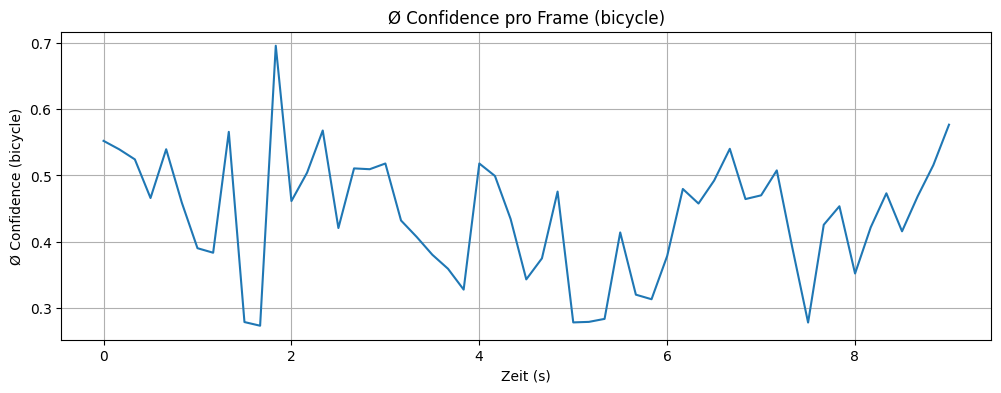

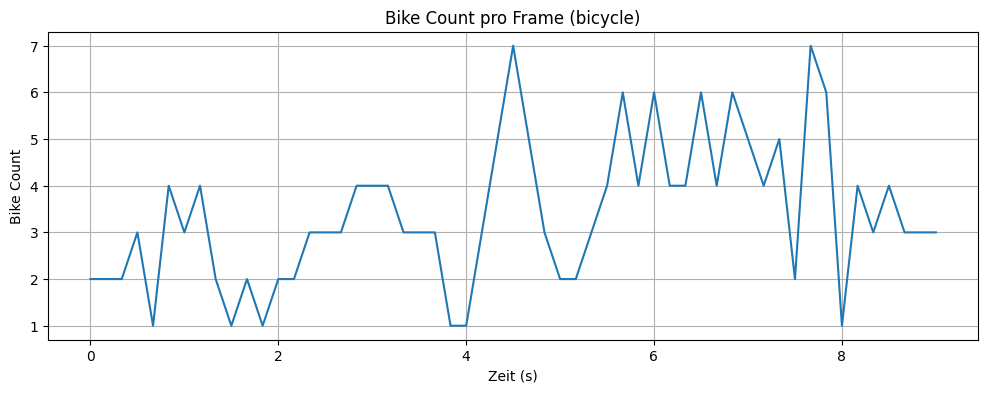

In [13]:
# ============================================================
# 8. Debugging & Failure-Mode-Analyse (systematisch)
# ============================================================
# Ziel:
# - Frames finden, in denen das Modell "schlecht" performt
# - typische Ursachen sichtbar machen (Überlappung, Winkel, Verdeckung, etc.)
# Vorgehen:
# (A) Kennzahlen / Proxy-Metriken pro Frame berechnen (z.B. Ø confidence, Anzahl Boxen)
# (B) "verdächtige" Frames automatisch vorschlagen (z.B. plötzliche Drops, sehr viele low-conf detections)
# (C) diese Frames visuell inspizieren (Bounding Boxes im Bild)
# (D) kurz dokumentieren: was ist der vermutete Failure Mode?

def frame_level_summary(df_det: pd.DataFrame) -> pd.DataFrame:
    """Aggregiert Detection-Kennzahlen pro Frame (nur bicycles)."""
    if df_det.empty:
        return pd.DataFrame(columns=["frame_idx","time_s","bike_count","conf_mean","conf_min","area_mean","aspect_mean"])

    df_bike = df_det[df_det["class_id"] == BICYCLE_CLASS_ID].copy()
    if df_bike.empty:
        return pd.DataFrame(columns=["frame_idx","time_s","bike_count","conf_mean","conf_min","area_mean","aspect_mean"])

    summary = (
        df_bike.groupby(["frame_idx","time_s"], as_index=False)
               .agg(
                   bike_count=("class_id","size"),
                   conf_mean=("conf","mean"),
                   conf_min=("conf","min"),
                   area_mean=("area","mean"),
                   aspect_mean=("aspect","mean")
               )
    )
    return summary

frame_sum = frame_level_summary(df_det)
display(frame_sum.head(10))

# Quick Plots: Confidence und Bike-Count
if len(frame_sum) > 0:
    plt.figure(figsize=(12,4))
    plt.plot(frame_sum["time_s"], frame_sum["conf_mean"])
    plt.xlabel("Zeit (s)")
    plt.ylabel("Ø Confidence (bicycle)")
    plt.title("Ø Confidence pro Frame (bicycle)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(frame_sum["time_s"], frame_sum["bike_count"])
    plt.xlabel("Zeit (s)")
    plt.ylabel("Bike Count")
    plt.title("Bike Count pro Frame (bicycle)")
    plt.grid(True)
    plt.show()


In [14]:
# ============================================================
# 9. Automatisch "verdächtige" Frames finden
# ============================================================
# Heuristiken (Debug-Trigger):
# 1) Low confidence: Frames mit sehr tiefer Ø confidence
# 2) Sudden drop: Frames, wo bike_count stark abfällt (kann Überlappung/Verdeckung oder Tracking-Problem sein)
# 3) Very small boxes: kann auf falsche Detections oder entfernte Objekte hindeuten

def suggest_suspicious_frames(frame_sum: pd.DataFrame, top_k: int = 10) -> dict:
    """Gibt Vorschlagslisten für Frames, die potenziell problematisch sind."""
    out = {}
    if frame_sum.empty:
        return out

    # 1) Low mean confidence
    out["low_conf"] = frame_sum.nsmallest(top_k, "conf_mean")[["frame_idx","time_s","bike_count","conf_mean"]]

    # 2) Sudden drop in bike_count (Differenzen)
    fs = frame_sum.sort_values("frame_idx").copy()
    fs["delta_count"] = fs["bike_count"].diff()  # negative Werte = Drop
    out["sudden_drop"] = fs.nsmallest(top_k, "delta_count")[["frame_idx","time_s","bike_count","delta_count","conf_mean"]]

    # 3) Very small mean area
    out["small_boxes"] = frame_sum.nsmallest(top_k, "area_mean")[["frame_idx","time_s","bike_count","area_mean","conf_mean"]]

    return out

suggestions = suggest_suspicious_frames(frame_sum, top_k=10)

for k, df in suggestions.items():
    print(f"\n--- Vorschläge: {k} ---")
    display(df)



--- Vorschläge: low_conf ---


,frame_idx,time_s,bike_count,conf_mean
10,50,1.667282,2,0.273184
45,225,7.502768,2,0.277953
30,150,5.001845,2,0.278192
9,45,1.500554,1,0.278709
31,155,5.168573,2,0.278988
32,160,5.335301,3,0.283507
35,175,5.835486,4,0.313158
34,170,5.668758,6,0.320055
23,115,3.834748,1,0.327682
27,135,4.501661,7,0.343129



--- Vorschläge: sudden_drop ---


,frame_idx,time_s,bike_count,delta_count,conf_mean
48,240,8.002952,1,-5.0,0.352015
45,225,7.502768,2,-3.0,0.277953
4,20,0.666913,1,-2.0,0.539551
8,40,1.333825,2,-2.0,0.565815
23,115,3.834748,1,-2.0,0.327682
28,140,4.668389,5,-2.0,0.374889
29,145,4.835117,3,-2.0,0.475699
35,175,5.835486,4,-2.0,0.313158
37,185,6.168942,4,-2.0,0.479607
40,200,6.669127,4,-2.0,0.540220



--- Vorschläge: small_boxes ---


,frame_idx,time_s,bike_count,area_mean,conf_mean
0,0,0.000000,2,105155.511719,0.552198
34,170,5.668758,6,125647.610026,0.320055
1,5,0.166728,2,126722.140625,0.539446
37,185,6.168942,4,129192.212891,0.479607
3,15,0.500185,3,134585.460938,0.465944
31,155,5.168573,2,142401.250977,0.278988
9,45,1.500554,1,143942.796875,0.278709
27,135,4.501661,7,145977.215123,0.343129
2,10,0.333456,2,155209.085938,0.524249
28,140,4.668389,5,158433.721094,0.374889


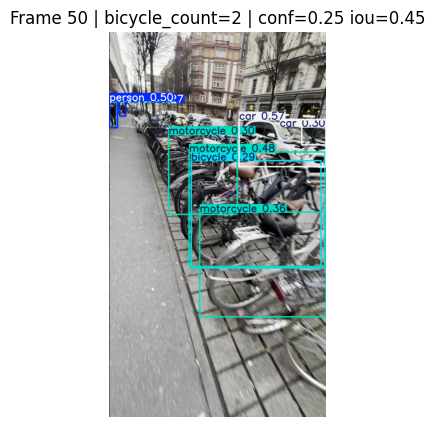

In [15]:
# ============================================================
# 10. Visuelles Debugging: Frame rendern + Bounding Boxes
# ============================================================

def read_frame(video_path: Path, frame_idx: int) -> np.ndarray:
    """Liest einen bestimmten Frame aus dem Video (BGR)."""
    cap = open_video_or_raise(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)   # Position setzen
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise RuntimeError(f"Konnte Frame {frame_idx} nicht lesen.")
    return frame

def render_debug_frame(video_path: Path, frame_idx: int, conf_thres: float = CONF_THRES, iou_thres: float = IOU_THRES):
    """Rendert einen Frame mit YOLO-Overlay (Bounding Boxes)."""
    frame_bgr = read_frame(video_path, frame_idx)             # Frame laden
    results = model.predict(frame_bgr, conf=conf_thres, iou=iou_thres, verbose=False)  # YOLO
    plotted = results[0].plot()                               # Overlay als Bild (BGR)

    # Zusätzlich: Zählung der bicycles in diesem Frame
    boxes = results[0].boxes
    bicycle_count = 0
    if boxes is not None and len(boxes) > 0:
        cls = boxes.cls.cpu().numpy().astype(int)
        bicycle_count = int(np.sum(cls == BICYCLE_CLASS_ID))

    plt.figure(figsize=(7,5))
    plt.imshow(plotted[:, :, ::-1])                           # BGR -> RGB
    plt.title(f"Frame {frame_idx} | bicycle_count={bicycle_count} | conf={conf_thres} iou={iou_thres}")
    plt.axis("off")
    plt.show()

# Beispiel: Einen problematischen Frame aus den Vorschlägen anzeigen
# Wähle z.B. den ersten Frame aus low_conf:
if "low_conf" in suggestions and len(suggestions["low_conf"]) > 0:
    example_frame = int(suggestions["low_conf"].iloc[0]["frame_idx"])
    render_debug_frame(VIDEO_PATH, example_frame)
else:
    print("Keine Vorschläge vorhanden (evtl. keine detections).")


In [16]:
# ============================================================
# 11. Manuelle Stichprobe für eine Mini-Evaluation (MAE/MAPE)
# ============================================================
# Ziel:
# - Nicht das gesamte Video labeln
# - Sondern nur eine kleine Stichprobe (z.B. 20 Frames)
# - Pro Frame: 'true_bike_count' manuell eingeben
# - Dann: Fehlermaße berechnen und diskutieren

ANNOTATION_FILE = OUTPUT_DIR / "manual_annotations.csv"  # Hier speichern wir die Labels

def sample_frames_for_annotation(frame_sum: pd.DataFrame, n: int = 20) -> list[int]:
    """Zieht eine Stichprobe von Frames (gleichmäßig über Zeit)."""
    if frame_sum.empty:
        return []
    # Wir wählen Frames aus den vorhandenen frames (nach stride)
    frames = frame_sum["frame_idx"].tolist()
    if len(frames) <= n:
        return frames
    # Gleichmäßige Auswahl über die Liste
    idxs = np.linspace(0, len(frames)-1, n).astype(int)
    return [frames[i] for i in idxs]

frames_to_label = sample_frames_for_annotation(frame_sum, n=20)
print("Frames zum Labeln (Vorschlag):", frames_to_label[:10], "... total:", len(frames_to_label))

def init_annotation_table(frames: list[int], frame_sum: pd.DataFrame) -> pd.DataFrame:
    """Erstellt eine Annotationstabelle mit YOLO-Prediction und Platz für Ground Truth."""
    if not frames:
        return pd.DataFrame(columns=["frame_idx","time_s","yolo_bike_count","true_bike_count","notes"])
    sub = frame_sum[frame_sum["frame_idx"].isin(frames)][["frame_idx","time_s","bike_count","conf_mean"]].copy()
    sub = sub.rename(columns={"bike_count":"yolo_bike_count"})
    sub["true_bike_count"] = np.nan  # wird manuell befüllt
    sub["notes"] = ""                # optional: Notizen (Überlappung, Kindersitz, etc.)
    return sub.sort_values("frame_idx")

ann_df = init_annotation_table(frames_to_label, frame_sum)
display(ann_df.head())

print(f"Speichere/aktualisiere {ANNOTATION_FILE} (lokal).")
ann_df.to_csv(ANNOTATION_FILE, index=False)


Frames zum Labeln (Vorschlag): [0, 10, 25, 40, 55, 70, 85, 95, 110, 125] ... total: 20


,frame_idx,time_s,yolo_bike_count,conf_mean,true_bike_count,notes
0,0,0.000000,2,0.552198,NaN,
2,10,0.333456,2,0.524249,NaN,
5,25,0.833641,4,0.458887,NaN,
8,40,1.333825,2,0.565815,NaN,
11,55,1.834010,1,0.695817,NaN,


Speichere/aktualisiere /Users/dominicwagenhofer/Desktop/Studium/7. Semester/Artificial Intelligence/Einzelarbeit/Git Repo/eds-ai-git/notebooks/notebooks/outputs/manual_annotations.csv (lokal).


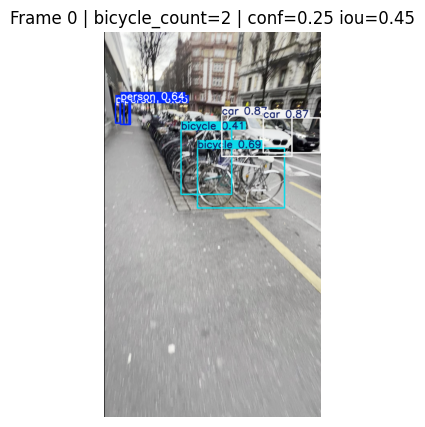

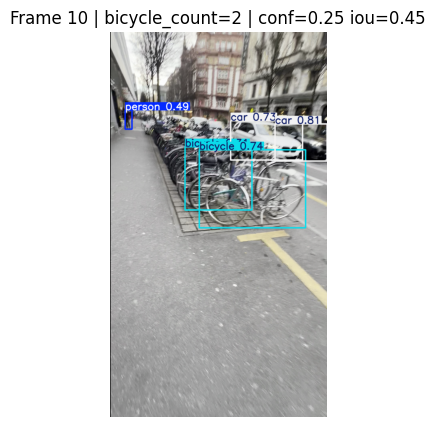

MAE  (Mean Absolute Error): nan
MAPE (Mean Absolute Percentage Error, ohne true=0): nan


,frame_idx,time_s,yolo_bike_count,conf_mean,true_bike_count,notes,abs_error,ape


In [17]:
# ============================================================
# 12. Annotation-Workflow (praktisch)
# ============================================================
# Anleitung:
# 1) Öffne die CSV: notebooks/outputs/manual_annotations.csv
# 2) Für jeden frame_idx:
#    - Render das Bild mit render_debug_frame(...)
#    - Zähle die Velos manuell im Bild
#    - Trage den Wert in true_bike_count ein
#    - Optional: notes (z.B. 'Überlappung', 'Verdeckung', 'Kindersitz', 'Winkel')
# 3) Speichere die CSV
# 4) Dann diese Zelle ausführen, um MAE/MAPE zu berechnen

def load_annotations(path: Path) -> pd.DataFrame:
    """Lädt die Annotationen."""
    if not path.exists():
        raise FileNotFoundError(f"Annotation file nicht gefunden: {path}")
    return pd.read_csv(path)

def evaluate_annotations(df_ann: pd.DataFrame) -> pd.DataFrame:
    """Berechnet Fehlermaße zwischen YOLO und Ground Truth."""
    df = df_ann.copy()
    df = df.dropna(subset=["true_bike_count"])  # nur gelabelte Zeilen
    df["true_bike_count"] = df["true_bike_count"].astype(int)
    df["abs_error"] = (df["yolo_bike_count"] - df["true_bike_count"]).abs()
    df["ape"] = df["abs_error"] / (df["true_bike_count"].replace(0, np.nan))  # APE; true=0 -> NaN
    mae = df["abs_error"].mean() if len(df) else np.nan
    mape = df["ape"].mean() if len(df) else np.nan
    print(f"MAE  (Mean Absolute Error): {mae}")
    print(f"MAPE (Mean Absolute Percentage Error, ohne true=0): {mape}")
    return df

# Beispiel: 2 Frames direkt anzeigen (damit du schnell labeln kannst)
if len(frames_to_label) >= 2:
    render_debug_frame(VIDEO_PATH, int(frames_to_label[0]))
    render_debug_frame(VIDEO_PATH, int(frames_to_label[1]))

# Evaluation (läuft erst sinnvoll, wenn du true_bike_count ausgefüllt hast)
try:
    df_ann_loaded = load_annotations(ANNOTATION_FILE)
    df_eval = evaluate_annotations(df_ann_loaded)
    display(df_eval.head())
except Exception as e:
    print("Noch keine (vollständigen) Annotationen vorhanden oder Fehler:", e)


## 13. Interpretation & Limitationen

### Was erklärt die Performance?
YOLOv8 ist auf dem COCO-Datensatz vortrainiert. Dort sind Fahrräder häufig **voll sichtbar**, mit **klarer Perspektive** und weniger **Objekt-Überlappung**.
In einer realen Veloparkierungsanlage treten jedoch typische Failure Modes auf:
- **Überlappung / Okklusion:** mehrere Velos stehen dicht → Unterzählung.
- **Ungewöhnliche Geometrie:** Cargo-Bikes, Kindersitze, Anhänger → Boxen können falsch sitzen.
- **Perspektive / Winkel:** Frontansicht, Schräglage → weniger charakteristische Features.
- **Motion Blur / Licht / Schatten:** verringert Confidence und/oder führt zu False Positives.

### Was wäre der nächste Schritt?
- **Finetuning** mit eigenen gelabelten Frames aus der Anlage (Domain Adaptation).
- Alternativ: **Tracking** (z.B. ByteTrack/SORT) um stabile Zählungen über Zeit zu erhalten.

### Wichtig für das Video
Zeige 2–3 gute Frames und 2–3 problematische Frames (aus dem Debugging). Erkläre kurz die Ursache und verknüpfe es mit der Zielsetzung/Metrik. fileciteturn1file0